<a href="https://colab.research.google.com/github/vitorgaboardi/deep-learning/blob/main/Hand_gesture_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install -q (quiet)
!pip install git+https://github.com/keras-team/keras-tuner.git -q

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import kerastuner
import IPython

In [ ]:
print('TF version:', tf.__version__)

TF version: 2.3.0


# 1.0 Case study I: signs dataset

## 1.1 Introduction


One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the [SIGNS dataset](https://www.kaggle.com/datamunge/sign-language-mnist). The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.


<center><img width="600" src="https://drive.google.com/uc?export=view&id=1Qz_B0IjzLrp77cBWIz6DVTsG3l9PSFKr"></center>
<center><b>Figure 1</b>: SIGNS dataset <br></center>


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import time
import datetime
import pytz
from mlxtend.plotting import plot_decision_regions

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



Run the following code to load the dataset.

In [ ]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


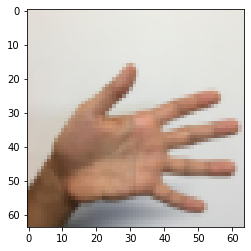

In [ ]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [ ]:
# Normalize image vectors
train_x = X_train_orig/255.
test_x = X_test_orig/255.
# Convert training and test labels to one hot matrices
train_y = tf.keras.utils.to_categorical(Y_train_orig).squeeze()
test_y = tf.keras.utils.to_categorical(Y_test_orig).squeeze()

print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 1.2 - Callback and helper functions

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))
    print('Duration: {}s'.format(time.time() - self.begins))

In [ ]:
def print_analysis(titles,history):
  loss = ["loss", "val_loss"]
  accuracy = ["categorical_accuracy","val_categorical_accuracy"]
  f, axs = plt.subplots(1,2,figsize=(10,4))
  
  for i,item in enumerate([loss,accuracy]):
    axs[i].plot(history.history[item[0]])
    axs[i].plot(history.history[item[1]])
    axs[i].set_ylabel(item[0])
    axs[i].set_xlabel('epoch')
    axs[i].legend(['train', 'test'], loc='best')
    if i == 1:
      axs[i].set_ylim(0,1)

  f.suptitle(titles, y=1.1)
  plt.tight_layout()
  plt.show()

In [ ]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)

# Normalize image vectors
train_base_x = X_train_flatten/255.
test_base_x = X_test_flatten/255.
# Convert training and test labels to one hot matrices
train_y = tf.keras.utils.to_categorical(Y_train_orig).squeeze()
test_y = tf.keras.utils.to_categorical(Y_test_orig).squeeze()

print ("number of training examples = " + str(train_base_x.shape[0]))
print ("number of test examples = " + str(test_base_x.shape[0]))
print ("X_train shape: " + str(train_base_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_base_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 12288)
Y_train shape: (1080, 6)
X_test shape: (120, 12288)
Y_test shape: (120, 6)


# 2 Baseline Model

In [ ]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(25, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(6, activation = tf.nn.softmax,kernel_initializer="he_uniform")
                             ])

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_base_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_base_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 2020-11-14 18:21:15
Training: ends at 2020-11-14 18:23:55
Duration: 159.81876945495605s


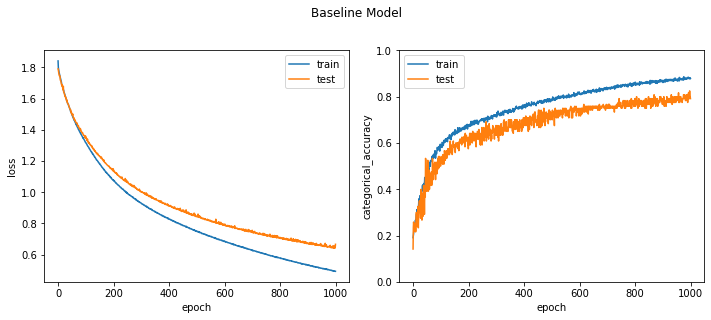

In [ ]:
print_analysis("Baseline Model", history)

In [ ]:
loss, acc = model.evaluate(x=train_base_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_base_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 2ms/step - loss: 0.5001 - categorical_accuracy: 0.8824
Train loss: 0.500 - acc: 0.882
4/4 [==============================] - 0s 3ms/step - loss: 0.6657 - categorical_accuracy: 0.7917
Test loss: 0.666 - acc: 0.792


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                307225    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________


# 3 Hyperparameter Tuning

The [Keras Tuner](https://github.com/keras-team/keras-tuner) is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called **hyperparameter tuning** or **hypertuning**. 

Hyperparameters are the variables that govern the training process and the topology of an ML model. These variables remain constant over the training process and directly impact the performance of your ML program. Hyperparameters are of two types:
1. **Model hyperparameters** which influence model selection such as the number and width of hidden layers
2. **Algorithm hyperparameters** which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) and the number of nearest neighbors for a k Nearest Neighbors (KNN) classifier

## 3.1 Define the model

When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a **hypermodel**.

You can define a hypermodel through two approaches:

* By using a model builder function
* By subclassing the `HyperModel` class of the Keras Tuner API

You can also use two pre-defined `HyperModel` classes - [HyperXception](https://keras-team.github.io/keras-tuner/documentation/hypermodels/#hyperxception-class) and [HyperResNet](https://keras-team.github.io/keras-tuner/documentation/hypermodels/#hyperresnet-class) for computer vision applications.

In this section, you use a model builder function to define the image classification model. The model builder function returns a compiled model and uses hyperparameters you define inline to hypertune the model.

In [ ]:
def model_builder(hp):
  # Instantiate a simple classification model
  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 20-40 with step 5
  hp_units = hp.Int('units', min_value = 20, max_value = 40, step = 5)
  model.add(tf.keras.layers.Dense(hp_units, activation=tf.nn.relu,kernel_initializer="he_uniform"))

  model.add(tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform"))
  model.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax,kernel_initializer="he_uniform"))

  # Instantiate a logistic loss function that expects integer targets
  loss = tf.keras.losses.CategoricalCrossentropy()

  # Instantiate an accuracy metric.
  accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Tune the learning rate 
  # Choose an optimal value between 1e-4 to 1e-2
  optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Float('lrate_sgd',
                                                             min_value=1e-4,
                                                             max_value=1e-2,
                                                             sampling='LOG'))

  # configure the optimizer, loss, and metrics to monitor.
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy]) 

  return model


Instantiate the tuner to perform the hypertuning. The Keras Tuner has [four tuners available](https://keras-team.github.io/keras-tuner/documentation/tuners/) - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`. 

Notice that in previous subsection we're not fitting there, and we're returning the compiled model. Let's continue to build out the rest of our program first, then we'll make things more dynamic. Adding the dynamic bits will all happen in the **model_builder** function, but we will need some other code that will use this function now.  To start, we're going to import **RandomSearch** and after that we'll first define our tuner.

In [ ]:
from kerastuner.tuners import RandomSearch

In [68]:
# path to store results
LOG_DIR = f"{int(time.time())}"

In [69]:
tuner = RandomSearch(model_builder,
                     objective='categorical_accuracy',
                     max_trials=6,  # how many model configurations would you like to test?
                     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
                     directory=LOG_DIR,
                     project_name="500_epochs"
                     )

Run the hyperparameter search. The arguments for the search method are the same as those used for [`tf.keras.model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).


Before running the hyperparameter search, define a callback to clear the training outputs at the end of every training step.

In [70]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(train_base_x,
             train_y, 
             epochs = 500, 
             verbose=1,
             batch_size=32,
             validation_data = (test_base_x,test_y),
             callbacks = [ClearTrainingOutput()])

Trial 1 Complete [00h 01m 50s]
categorical_accuracy: 0.1675925999879837

Best categorical_accuracy So Far: 0.1675925999879837
Total elapsed time: 00h 01m 50s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
units             |35                |40                
lrate_sgd         |0.001133          |0.0010961         

Epoch 1/500
34/34 [==============================] - 0s 11ms/step - loss: 1.8291 - categorical_accuracy: 0.1806 - val_loss: 1.8088 - val_categorical_accuracy: 0.1917
Epoch 2/500
34/34 [==============================] - 0s 6ms/step - loss: 1.7823 - categorical_accuracy: 0.2093 - val_loss: 1.7634 - val_categorical_accuracy: 0.2167
Epoch 3/500
34/34 [==============================] - 0s 6ms/step - loss: 1.7561 - categorical_accuracy: 0.2444 - val_loss: 1.7202 - val_categorical_accuracy: 0.2167
Epoch 4/500
34/34 [==============================] - 0s 6ms/step - loss: 1.7404 - categorical_accuracy: 0.2713 - val_loss: 1.7701 - val_categorical

In [72]:
# print a summary of results
tuner.results_summary(num_trials=3)

Results summary
Results in 1605541998/500_epochs
Showing 3 best trials
Objective(name='categorical_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 35
lrate_sgd: 0.0011329586419415488
Score: 0.9990741014480591
Trial summary
Hyperparameters:
units: 30
lrate_sgd: 0.0003897880024392752
Score: 0.9537037014961243
Trial summary
Hyperparameters:
units: 40
lrate_sgd: 0.00043230060320522735
Score: 0.9509259462356567


In [73]:
# best hyperparameters is a dictionary
tuner.get_best_hyperparameters()[0].values

{'lrate_sgd': 0.0011329586419415488, 'units': 35}

In [74]:
# search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 40, 'step': 5, 'sampling': None}
lrate_sgd (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [75]:
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {tuner.get_best_hyperparameters()[0].values.get('units')}""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 35


Retrain the model with the optimal hyperparameters

In [78]:
# Build the model with the optimal hyperparameters and train it on the data
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_base_x, train_y, epochs = 500, validation_data = (test_base_x, test_y),batch_size=32)

Epoch 1/500
34/34 [==============================] - 0s 9ms/step - loss: 1.8066 - categorical_accuracy: 0.1574 - val_loss: 1.7870 - val_categorical_accuracy: 0.1833
Epoch 2/500
34/34 [==============================] - 0s 6ms/step - loss: 1.7911 - categorical_accuracy: 0.1833 - val_loss: 1.7904 - val_categorical_accuracy: 0.1917
Epoch 3/500
34/34 [==============================] - 0s 6ms/step - loss: 1.7868 - categorical_accuracy: 0.2167 - val_loss: 1.7816 - val_categorical_accuracy: 0.2333
Epoch 4/500
34/34 [==============================] - 0s 6ms/step - loss: 1.7872 - categorical_accuracy: 0.1806 - val_loss: 1.7787 - val_categorical_accuracy: 0.2583
Epoch 5/500
34/34 [==============================] - 0s 5ms/step - loss: 1.7726 - categorical_accuracy: 0.2167 - val_loss: 1.7574 - val_categorical_accuracy: 0.2750
Epoch 6/500
34/34 [==============================] - 0s 5ms/step - loss: 1.7557 - categorical_accuracy: 0.2324 - val_loss: 1.7632 - val_categorical_accuracy: 0.2167
Epoch 7/50

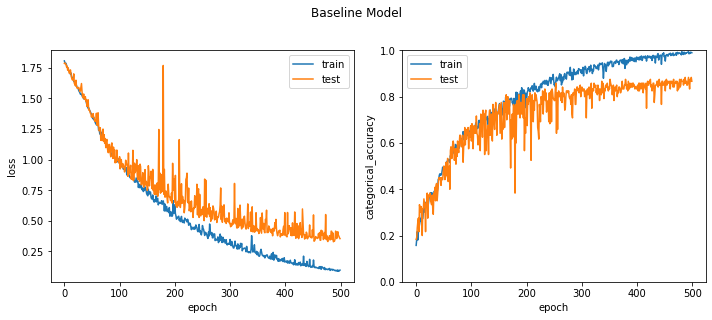

In [79]:
print_analysis("Baseline Model", history)

In [80]:
loss, acc = model.evaluate(x=train_base_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_base_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 2ms/step - loss: 0.0907 - categorical_accuracy: 0.9880
Train loss: 0.091 - acc: 0.988
4/4 [==============================] - 0s 3ms/step - loss: 0.3549 - categorical_accuracy: 0.8667
Test loss: 0.355 - acc: 0.867


# 4 - Batch Normalization

Training deep neural networks with tens of layers is challenging as they can be sensitive to the initial random weights and configuration of the learning algorithm. One possible reason for this dificulty is the distribution of the inputs to layers deep in the network may change after each minibatch when the weights are updated. This can cause the learning algorithm to forever chase a moving target.

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each minibatch. This technique accelerates training, in some cases by halving the number of epochs (or better), and provides some regularization effect, reducing generalization error.

In [85]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(35, kernel_initializer="he_uniform"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation(tf.nn.relu))

model.add(tf.keras.layers.Dense(12,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation(tf.nn.relu))

model.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax,kernel_initializer="he_uniform"))

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001132) 

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_base_x,
                    y=train_y,
                    batch_size=32,
                    epochs=500,
                    validation_data=(test_base_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 2020-11-16 14:46:59
Training: ends at 2020-11-16 14:48:31
Duration: 92.5764410495758s


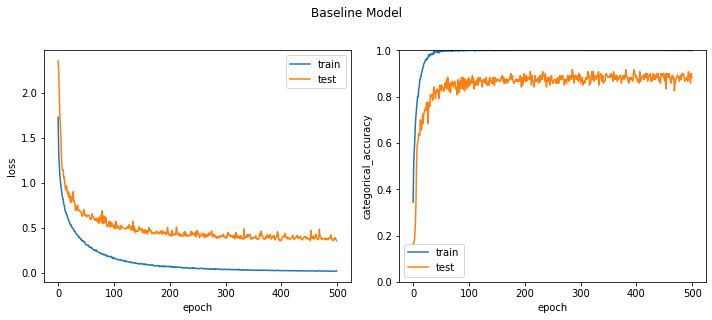

In [86]:
print_analysis("Baseline Model", history)

In [87]:
loss, acc = model.evaluate(x=train_base_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_base_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 2ms/step - loss: 0.0135 - categorical_accuracy: 1.0000
Train loss: 0.013 - acc: 1.000
4/4 [==============================] - 0s 3ms/step - loss: 0.3566 - categorical_accuracy: 0.8833
Test loss: 0.357 - acc: 0.883


# 5 - Regularization

In [124]:
def model_builder(hp):
  # Instantiate a simple classification model
  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 20-40 with step 5
  hp1 = hp.Float('units', min_value = 0.008, max_value = 0.2, sampling = 'LOG')
  hp2 = hp.Float('units', min_value = 0.008, max_value = 0.2, sampling = 'LOG')

  model.add(tf.keras.layers.Dense(35, activation=tf.nn.relu,kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=hp1)))
  model.add(tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=hp2)))
  model.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax,kernel_initializer="he_uniform"))

  # Instantiate a logistic loss function that expects integer targets
  loss = tf.keras.losses.CategoricalCrossentropy()

  # Instantiate an accuracy metric.
  accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Tune the learning rate 
  # Choose an optimal value between 1e-4 to 1e-2
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001132)

  # configure the optimizer, loss, and metrics to monitor.
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy]) 

  return model

In [125]:
tuner = RandomSearch(model_builder,
                     objective='val_categorical_accuracy',
                     max_trials=6,  # how many model configurations would you like to test?
                     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
                     project_name="regularization"
                     )

INFO:tensorflow:Reloading Oracle from existing project ./regularization/oracle.json


In [ ]:
tuner.search(train_base_x,
             train_y, 
             epochs = 500, 
             verbose=1,
             batch_size=32,
             validation_data = (test_base_x,test_y),
             callbacks = [ClearTrainingOutput()])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |0.078419          |?                 
lrate_sgd         |0.0014002         |?                 

Epoch 1/500
34/34 [==============================] - 0s 11ms/step - loss: 9.1684 - categorical_accuracy: 0.1741 - val_loss: 9.1024 - val_categorical_accuracy: 0.1667
Epoch 2/500
34/34 [==============================] - 0s 7ms/step - loss: 9.0300 - categorical_accuracy: 0.1898 - val_loss: 8.9660 - val_categorical_accuracy: 0.1750
Epoch 3/500
34/34 [==============================] - 0s 7ms/step - loss: 8.9271 - categorical_accuracy: 0.2009 - val_loss: 8.8767 - val_categorical_accuracy: 0.2333
Epoch 4/500
34/34 [==============================] - 0s 7ms/step - loss: 8.8214 - categorical_accuracy: 0.2185 - val_loss: 8.7722 - val_categorical_accuracy: 0.2500
Epoch 5/500
34/34 [==============================] - 0s 7ms/step - loss: 8.7213 - categorical_accuracy: 0.2444 - val_loss: 8.7333 - val_cate

In [127]:
# print a summary of results
tuner.results_summary(num_trials=3)

Results summary
Results in ./regularization
Showing 3 best trials
Objective(name='val_categorical_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 0.01977321088287769
lrate_sgd: 0.008945203543008127
Score: 0.8999999761581421
Trial summary
Hyperparameters:
units: 0.03191300583839917
lrate_sgd: 0.0011304950051691499
Score: 0.875
Trial summary
Hyperparameters:
units: 0.011981036696188557
lrate_sgd: 0.0002655638826100355
Score: 0.8583333492279053


In [138]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(35, activation=tf.nn.relu,kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=0.01977321088287769)),
                             tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=0.008945203543008127)),
                             tf.keras.layers.Dense(6, activation = tf.nn.softmax,kernel_initializer="he_uniform")
                             ])

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001132)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_base_x,
                    y=train_y,
                    batch_size=32,
                    epochs=500,
                    validation_data=(test_base_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 2020-11-16 16:51:45
Training: ends at 2020-11-16 16:53:31
Duration: 106.69240736961365s


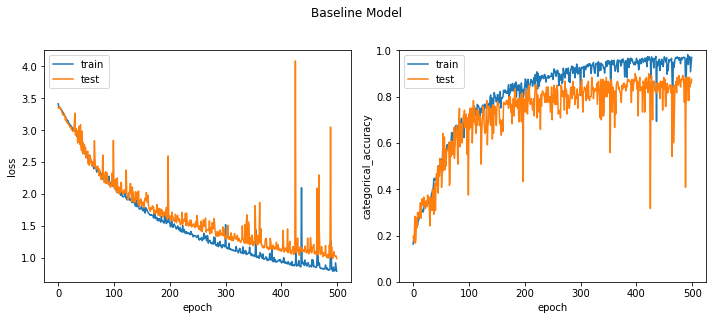

In [139]:
print_analysis("Baseline Model", history)

In [140]:
loss, acc = model.evaluate(x=train_base_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_base_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 3ms/step - loss: 0.7654 - categorical_accuracy: 0.9852
Train loss: 0.765 - acc: 0.985
4/4 [==============================] - 0s 3ms/step - loss: 0.9845 - categorical_accuracy: 0.8750
Test loss: 0.985 - acc: 0.875


# 5 CNN Model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (5,5), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Conv2D(32, (5,5), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

In [ ]:
# Instantiate a logistic loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=75,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

Training: begins at 2020-11-14 18:29:44
Epoch 1/75
34/34 [==============================] - 3s 98ms/step - loss: 1.7855 - categorical_accuracy: 0.2074 - val_loss: 1.7658 - val_categorical_accuracy: 0.2750
Epoch 2/75
34/34 [==============================] - 3s 94ms/step - loss: 1.6857 - categorical_accuracy: 0.3852 - val_loss: 1.6419 - val_categorical_accuracy: 0.4333
Epoch 3/75
34/34 [==============================] - 3s 95ms/step - loss: 1.5487 - categorical_accuracy: 0.5352 - val_loss: 1.5253 - val_categorical_accuracy: 0.5500
Epoch 4/75
34/34 [==============================] - 3s 95ms/step - loss: 1.4306 - categorical_accuracy: 0.6546 - val_loss: 1.4594 - val_categorical_accuracy: 0.6083
Epoch 5/75
34/34 [==============================] - 3s 96ms/step - loss: 1.3904 - categorical_accuracy: 0.6917 - val_loss: 1.3767 - val_categorical_accuracy: 0.6833
Epoch 6/75
34/34 [==============================] - 3s 97ms/step - loss: 1.3389 - categorical_accuracy: 0.7333 - val_loss: 1.3535 - val

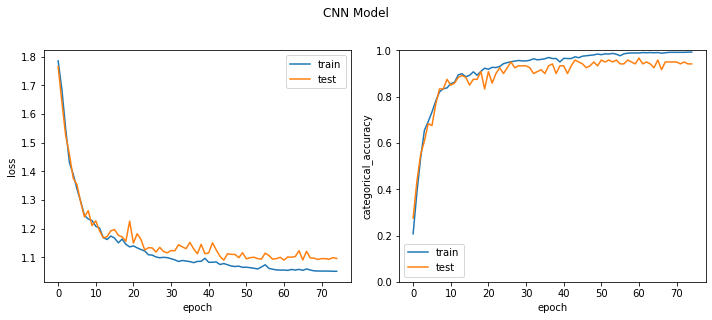

In [ ]:
print_analysis("CNN Model", history)

In [ ]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 1s 30ms/step - loss: 1.0512 - categorical_accuracy: 0.9926
Train loss: 1.051 - acc: 0.993
4/4 [==============================] - 0s 22ms/step - loss: 1.0963 - categorical_accuracy: 0.9417
Test loss: 1.096 - acc: 0.942


# 5.1 - Test with your own image

You can now take a picture of your hand and see the output of your model.

float32
(1, 64, 64, 3)


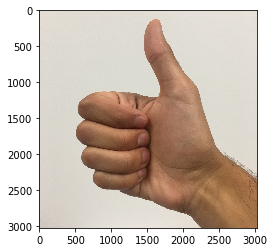

In [ ]:
# example of converting an image with the Keras API
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.transform import resize

# load the image
img = load_img('thumbs_up.jpg')

# convert to numpy array
img_array = img_to_array(img)/255
img_array_res = resize(img_array, (64,64)).reshape((1, 64,64,3))

print(img_array_res.dtype)
print(img_array_res.shape)

plt.imshow(img_array)

In [ ]:
model.predict(img_array_res).argmax()

3

# 6.0 References

https://github.com/ivanovitchm/deeplearning2020.6